In [505]:
import torch
from sklearn.preprocessing import MinMaxScaler 
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
import warnings
warnings.filterwarnings("ignore")

In [506]:
X=torch.randint(9,(1000,2)).to(torch.float32)
y=torch.sum(X,axis=1).reshape(-1,1)

In [507]:
# creating train test splits
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=.20,random_state=7)

Text(0.5, 1.0, 'Test Data')

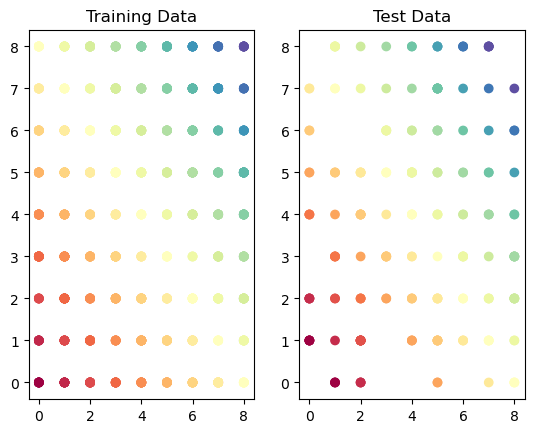

In [508]:
# Visualize the data
fig,(train_ax,test_ax)=plt.subplots(1,2)
train_ax.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap=plt.cm.Spectral)
test_ax.scatter(X_test[:,0],X_test[:,1],c=y_test,cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
test_ax.set_title("Test Data")
# plt.scatter(X[:,0],X[:,1])

In [509]:
# Get the Data
class Data(Dataset):
    def __init__(self,X,y):
        # self.X=torch.from_numpy(X.astype(np.float32))
        # # self.y=torch.from_numpy(y.astype(np.float32))
        self.X=X
        self.y=y
        self.len=self.X.shape[0]

    def __getitem__(self,index):
        return self.X[index],self.y[index]

    def __len__(self):
        return self.len

batch_size=64

# Instantiate training and test data
train_data=Data(X_train,y_train)
train_dataloader= DataLoader(train_data,batch_size=batch_size,shuffle=True)

test_data=Data(X_test,y_test)
test_dataloader= DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [539]:
train_data[0]

(tensor([8., 3.]), tensor([11.]))

In [537]:
train_data.__getitem__

<bound method Data.__getitem__ of <__main__.Data object at 0x000002524D9A3790>>

In [510]:
# Check its working
for batch ,(X,y) in enumerate(train_dataloader):
    print("Batch",batch+1)
    print("X shape",X.shape)
    print("y shape",y.shape)
    break
    

Batch 1
X shape torch.Size([64, 2])
y shape torch.Size([64, 1])


In [511]:
# Neural Network Implementation and Model training
import torch
from torch import nn
from torch import optim

input_dim=2
hidden_dim=40
output_dim=1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim,hidden_dim,output_dim):
        super(NeuralNetwork,self).__init__()
        self.layer1= nn.Linear(input_dim,6)  
        self.layer2= nn.Linear(6,12)
        self.layer3= nn.Linear(12,12)     
        self.layer4= nn.Linear(12,6)        
        self.layer5= nn.Linear(6,output_dim)
        

    def forward(self,x):
        x=torch.nn.functional.relu(self.layer1(x))
        x=torch.nn.functional.relu(self.layer2(x))
        x=torch.nn.functional.relu(self.layer3(x))
        x=torch.nn.functional.relu(self.layer4(x))
        x=self.layer5(x)
        return x


In [512]:
model= NeuralNetwork(input_dim,hidden_dim,output_dim)
print(model)

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=12, bias=True)
  (layer3): Linear(in_features=12, out_features=12, bias=True)
  (layer4): Linear(in_features=12, out_features=6, bias=True)
  (layer5): Linear(in_features=6, out_features=1, bias=True)
)


In [513]:
# To train the model we must define a loss function to use to calculate the gradients and 
# an optimizer to update the parameters.

learning_rate=0.1
loss_fn= nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate)

In [514]:
len(train_dataloader)

13

In [515]:
# train the model
epochs=500
loss_values=[]

for epoch in range(epochs):
    for X,y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward+backward+optimize
        preds= model(X)
        loss= loss_fn(preds,y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
print("Training complete")

Training complete


In [516]:
len(loss_values)

6500

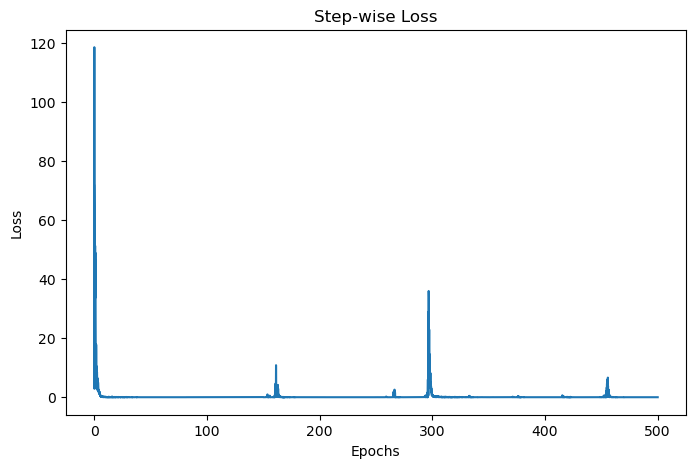

In [517]:
step = np.linspace(0, 500, 6500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [518]:
# prediction and Model Evaluation
"""
We're not training so we don't need to calculate the gradients for our outputs
"""
y_pred=[]
total=0
correct=0
with torch.no_grad():
    for X,y in test_dataloader:
        outputs=torch.ceil(model(X))
        y_pred.append(outputs)
        # y_test.numpy().append(y)
        total+=y.size(0)
        correct+=outputs.eq(y).sum().item()
print(f'Accuracy of the network on the 200 test instances: {100 * correct // total}%')

"""
Accuracy of the network on the 3300 test instances: 97%
"""

Accuracy of the network on the 200 test instances: 94%


'\nAccuracy of the network on the 3300 test instances: 97%\n'

In [527]:
random_seed=42
torch.manual_seed(random_seed)
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for testing. We can do this using the `random_spilt` method from PyTorch.

In [528]:
# device config
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparams
input_size=784
batch_size=64
learning_rate=0.001
num_classes=10
epochs=25

In [530]:
# Get the data
train_set= torchvision.datasets.MNIST(root="data",
                                      train=True,
                                      transform=transforms.ToTensor(),
                                      download=True
                                     )

test_set= torchvision.datasets.MNIST(root="data",
                                    train=False,
                                    transform=transforms.ToTensor())                                             

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [531]:
## create DataLoader
train_loader=torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)

test_loader= torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

labels tensor([6, 4, 7, 6, 7, 8, 8, 1, 3, 6, 7, 9, 2, 1, 1, 8, 1, 0, 4, 1, 9, 8, 2, 0,
        4, 0, 7, 7, 2, 4, 9, 3, 9, 8, 1, 0, 1, 6, 8, 1, 0, 1, 8, 0, 6, 0, 2, 8,
        2, 4, 4, 2, 5, 6, 5, 1, 2, 3, 2, 9, 2, 9, 0, 1])


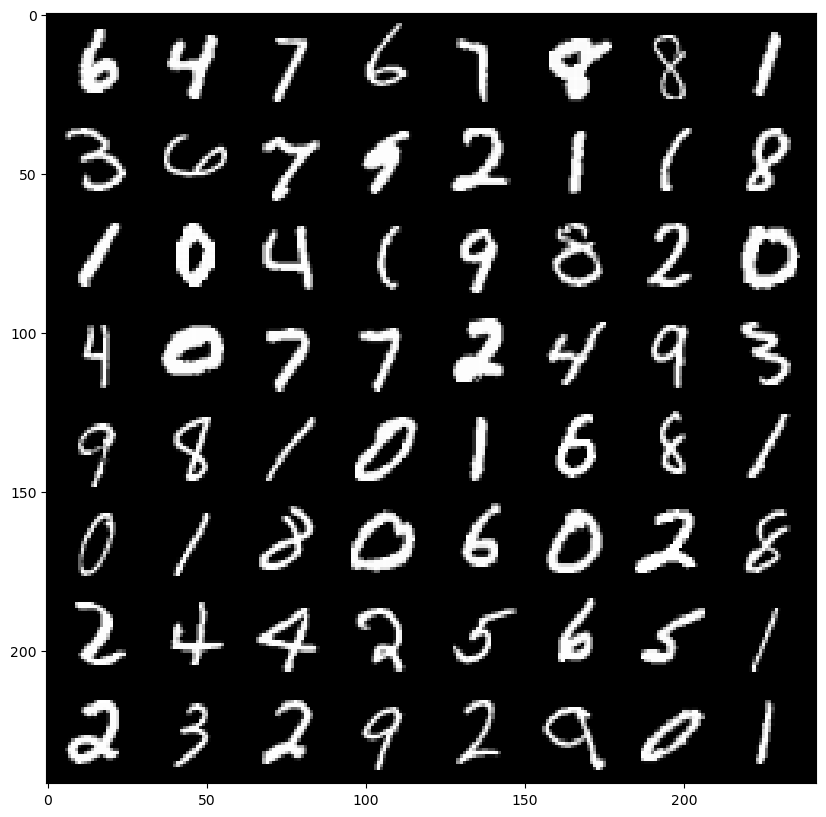

In [535]:
## look at one batch of data
images,labels=next(iter(train_loader))
grid=torchvision.utils.make_grid(images,nrows=10)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid,(1,2,0)))
print("labels",labels)

In [638]:
class Data(Dataset):
    def __init__(self,data):
        self.data=data

    def __getitem__(self,index):
        image=self.data[index][0]
        label=self.data[index][1]               
        rand_num=random.randint(0,10)        
        sum_=label+rand_num
        sample={"image":image,"numeric_data":torch.FloatTensor([label,rand_num]),"label":{"image_label":label,"sum":sum_}}
        return sample

    def __len__(self):
        return len(self.data)    

In [639]:
train_data=Data(train_set)
test_data=Data(test_set)

In [640]:
train_loader= torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=False)

In [641]:
sample=next(iter(train_loader))
print("Keys in our sample batch:",sample.keys())
print("Size of images",sample["image"].shape)
print("Size of numeric data",sample["numeric_data"].shape)
print("Size of target in our sample batch",sample["label"]["image_label"].shape)

Keys in our sample batch: dict_keys(['image', 'numeric_data', 'label'])
Size of images torch.Size([64, 1, 28, 28])
Size of numeric data torch.Size([64, 2])
Size of target in our sample batch torch.Size([64])


torch.Size([64, 1, 28, 28])
tensor([[ 7.,  6.],
        [ 5.,  0.],
        [ 6.,  7.],
        [ 7.,  4.],
        [ 4.,  6.],
        [ 7.,  7.],
        [ 4.,  9.],
        [ 2.,  3.],
        [ 8.,  7.],
        [ 6.,  8.],
        [ 6., 10.],
        [ 8.,  3.],
        [ 6.,  9.],
        [ 7.,  2.],
        [ 3.,  2.],
        [ 6., 10.],
        [ 6.,  9.],
        [ 7.,  2.],
        [ 6.,  6.],
        [ 7., 10.],
        [ 5.,  2.],
        [ 2.,  1.],
        [ 5.,  4.],
        [ 4.,  6.],
        [ 2.,  1.],
        [ 9.,  0.],
        [ 5.,  4.],
        [ 2.,  4.],
        [ 1.,  1.],
        [ 9.,  3.],
        [ 0.,  2.],
        [ 4.,  2.],
        [ 6.,  1.],
        [ 7.,  2.],
        [ 2.,  4.],
        [ 4.,  8.],
        [ 1.,  1.],
        [ 3.,  1.],
        [ 9.,  6.],
        [ 3.,  3.],
        [ 3.,  3.],
        [ 6.,  1.],
        [ 2.,  1.],
        [ 2.,  2.],
        [ 7., 10.],
        [ 6.,  4.],
        [ 2.,  9.],
        [ 4.,  0.],
        [ 8.

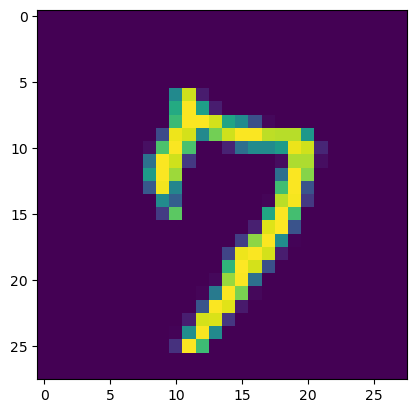

In [642]:
sample=next(iter(train_loader))
print(sample["image"].shape)
print(sample["numeric_data"])
print("label:",sample["label"]["image_label"])
print("sum:",sample["label"]["sum"])
plt.imshow(np.transpose(sample["image"][0],(1,2,0)))

Architecture

Now to get into the actual model. We need one convolutional neural network for our image data and a multi-layer perceptron for our tabular data. Both need to be combined and need to return a single prediction value. First, we define a single conv_block, a small custom CNN-layer that expects an input and output dimension. This will save us a bit of repetitive code writing later on.

In [608]:
import torch.nn.functional as F
def conv_block(in_ch,out_ch):
    block= nn.Sequential(nn.Conv2d(in_ch,out_ch,(3,3)),nn.ReLU(),nn.MaxPool2d(2,2))
    return block


In [679]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= conv_block(1,32)
        self.conv2= conv_block(32,64)
        self.conv3= conv_block(64,128)

        self.ln1= nn.Linear(128*1*1,64)
        self.relu=nn.ReLU()

        self.ln2= nn.Linear(64,10)
        self.ln3= nn.Linear(2,10)
        self.ln4= nn.Linear(10,10)
        self.ln5= nn.Linear(20,1)
            

        self.image_label= nn.Sequential(self.ln1,self.relu,self.ln2)
        
    def forward(self,img,tab):
        img= self.conv1(img)
        img= self.conv2(img)
        img= self.conv3(img)
        # the input for the classifier should be two-dimensional, but we will have
        # [<batch_size>, <channels>, <width>, <height>]
        # flatten the output of conv2 to (batch_size, 128 * 1 * 1)
        features= img.reshape(img.shape[0],-1)
        
        # create separate classifiers for our outputs
        output_label= self.image_label(features) # this will classify the image of the digit
        
        # output of regressor
        img=self.ln1(features)
        img= self.relu(img)
        img= self.ln2(img)# output of CNN
        img= self.relu(img)

        tab= self.ln3(tab)
        tab= self.relu(tab)
        tab= self.ln4(tab) # output of MLP
        tab= self.relu(tab)

        x= torch.cat((img,tab),dim=1) # concatenating the features extracted from CNN and MLP
        x= self.relu(x)
        x= self.ln5(x) # this will give the output of the addition operation
        return {"Sum":x, "img_label":output_label }    


The forward() function represents our architecture. The function accepts image and tabular(integer data) data. The image data is used as input data in the CNN layers. Then, we run the tabular data through the multi-layer perceptron. The secret of multi-input neural networks in PyTorch comes after the last tabular line: torch.cat() combines the output data of the CNN with the output data of the MLP. The output of our CNN has a size of 10; the output of the MLP is also 10. Combining the two gives us a new input size of 20 for the last linear layer. Since we are doing regression ,we do not need a softmax function in the end.

We create a flexible training routine that takes into account all outputs of our model. Therefore, it does not matter whether we have 2, 3 or, for example, 5 classifier heads. We simply use the conventional loss function for multiclassification tasks. We calculate the CrossEntropyLoss for digit classifier and for regression we need MSE and then we sum the Losses. This way we can optimize the weights with a single optimizer step for both the heads:

In [697]:
def criterion(net_output,ground_truth):
    classifier_loss= F.cross_entropy(net_output["img_label"],ground_truth["image_label"])
    regressor_loss= F.mse_loss(net_output["Sum"],ground_truth["sum"].to(torch.float32))
    loss= classifier_loss+regressor_loss

    return loss,{"img_labe":classifier_loss,"sum":regressor_loss}


Now we have both model and data ready. Let’s start the training.

In [681]:
epochs=10
batch_size=64
model=ConvNet().to(device)


In [694]:
for i, data in enumerate(train_loader):
    img= data["image"].to(device)
    tab= data["numeric_data"]
    print(data["label"]["sum"].dtype)
    outputs= model(img,tab)
    print(outputs["Sum"].shape)
    loss= criterion(outputs,data["label"])
    print(loss[0].item())
    break

torch.int64
torch.Size([64, 1])
102.3136978149414


In [647]:
for i, num in enumerate(range(100)):
    if (i+1)%(int(100))==0:
        print(i)

99


In [698]:
def training(model,epochs,training_data):
    num_epochs=epochs
    losses=[]
    checkpoint_losses = []

    optimizer= torch.optim.Adam(model.parameters(),lr=0.001)
    n_total_steps= len(train_loader)

    for epochs in range(num_epochs):
        for i, data in enumerate(train_loader):
            img= data["image"].to(device)
            tab= data["numeric_data"]
            outputs= model(img,tab)

            loss_train,_= criterion(outputs,data["label"])
            losses.append(loss_train.item())

            optimizer.zero_grad()
            loss_train.backward()

            optimizer.step()

            if(i+1)% int(n_total_steps/1)==0:
                checkpoint_loss = torch.tensor(losses).mean().item()
                checkpoint_losses.append(checkpoint_loss)
                print(f"epoch [{epochs+1}/{num_epochs}] Step [{i+1}/{n_total_steps}] Loss:{checkpoint_loss:.4f}] ")
    return checkpoint_losses

checkpoint_losses=training(model,epochs=10,training_data=train_loader)
            

epoch [1/10] Step [938/938] Loss:22.9203] 
